In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
import jax

# 強化学習を動的計画法で全部書く

参考
* [A Generalized ReinforcementLearning Model Convergence and Application](https://cs.brown.edu/~mlittman/papers/ml96-generalized.pdf)
* [Towards Characterizing Divergence in Deep Q-Learning](https://arxiv.org/abs/1903.08894)

Q学習みたいな要素毎の更新則も動的計画法でまとめて書きたいですよね。それを叶える便利なモデルがあります。

## データの分布と汎化と作用素

参考: [Towards Characterizing Divergence in Deep Q-Learning](https://arxiv.org/abs/1903.08894)

一旦Q学習を復習しましょう：

**価値反復法**
* ベルマン作用素: $TQ = r + \gamma P\max Q$
* 更新則: $Q_{t+1} \leftarrow T Q_t$

**Q学習**
* 近似ベルマン作用素: $\hat{T}Q(s, a) = r(s, a) + \gamma \max_{a'} Q(s', a')$
* 更新則: $Q_{t+1}(s_t, a_t) \leftarrow Q_{t}(s_t, a_t) + \alpha_t \left(\hat{T}Q_t(s_t, a_t) - Q_t(s_t, a_t)\right)$

この２つは次の行列計算で一般化できます

* 更新則: $Q_{t+1} \leftarrow Q_t + \alpha_t D_t \left(\hat{T} Q_t - Q_t\right)$

ここで、$D_t$は$|S||A|\times |S||A|$の対角行列で、その要素はデータに使用する状態行動$(s, a)$の分布になっています。
つまり、Q学習の場合は$D_t = \text{diag} [0, \cdots, 1, \cdots, 0]$です（$(s_t, a_t)$番目の要素だけ１）し、価値反復法の場合は$\alpha_t = |S||A|$ かつ $D_t = \text{diag} [1/|S||A|, \cdots, 1/|S||A|]$。
Replay bufferなどを使う場合もこれで表すことができます。

関数近似がある場合はどうなるでしょうか？

**適合Q学習**
* パラメータの更新: $\theta_{t+1} \leftarrow \theta_{t} + \alpha_t \mathbb{E}_{(s', a')\sim D}\left[\left(\hat{T}Q_{\theta_t}(s', a') - Q_{\theta_t}(s', a')\right)\nabla_{\theta_t} Q_{\theta_t}(s', a')\right]$
* 更新則: $Q_{t+1} \leftarrow Q_{\theta_{t+1}}$

これはテイラー展開すると、
* Neural Tangent Kernel: $k_\theta(s, a, s', a')=\nabla_{\theta_t} Q_{\theta_t}(s, a)^T\nabla_{\theta_t} Q_{\theta_t}(s', a')$
* 更新則: $Q_{t+1}(s, a) \leftarrow Q_{t}(s, a) + \alpha_t \mathbb{E}_{(s', a')\sim D}\left[k_{\theta_t}(s, a, s', a')\left(\hat{T}Q_{\theta_t}(s', a') - Q_{\theta_t}(s', a')\right)\right] + \mathcal{O}(\|\theta_{t+1}-\theta_{t}\|^2)$

これも次の行列計算で一般化できます

* 更新則: $Q_{t+1} \leftarrow Q_t + \alpha_t K_t D_t \left(\hat{T} Q_t - Q_t\right) + \mathcal{O}(\|\theta_{t+1}-\theta_{t}\|^2)$ 

ここで、$K_t$は$|S||A|\times |S||A|$の行列で、$K(s, a, s', a') = k(s, a, s', a')$です。線形近似で$Q_\theta = \theta^T \Phi$としている場合、$K = \Phi \Phi^T$です。(Linear MDPのことを考えるともっと面白い結果がでるかも？)

なんにせよ、この更新則も何らかの作用素$U_i: Q\mapsto Q$によって更新しています。
[論文](https://arxiv.org/abs/1903.08894)では、$U_0, U_1, \dots$が全て同じfixed-point $\tilde{Q}$を持ち、$U_i$が$\beta_i$リプシッツ連続で、$Q_{i+1}\leftarrow U_iQ_i$で更新され、

$$
\|\tilde{Q} - Q_i\| \leq \left(\prod_{k=0}^{i-1} \beta_k\right)\|\tilde{Q} - Q_0\|
$$

が任意の$i$で満たされているとき、$Q_i$が$\tilde{Q}$に収束することが証明されています(確率的にfixed-pointになる場合については言及されていません)。

試しに適合Q学習をこの形で書いてみます。

実験の前に、いくつか便利な関数を導入します。

1. ``compute_greedy_policy``: Q関数 ($S \times A \to \mathcal{R}$) の貪欲方策を返します
2. ``compute_optimal_Q``: MDPの最適Q関数 $q_* : S \times A \to \mathcal{R}$ を返します。
3. ``compute_policy_Q``: 方策 $\pi$ のQ関数 $q_\pi : S \times A \to \mathcal{R}$ を返します。
4. ``compute_optimality_gap``: 方策 $\pi$ と最適解との差 $\|q_* - q_{\pi}\|_\infty$ を返します。この値が小さいほど、$\pi$ はほぼ全ての状態行動対で最適な方策になっています。
5. ``sample_next_state``: $(s, a)$の次の状態をサンプルします。
6. ``sample_init_state``: 初期状態をサンプルします。
7. ``sample_eps_greedy_act``: 与えられたQ値から、epsilon-greedy方策に従って行動を返します

In [11]:
import random
from functools import partial
from typing import NamedTuple, Optional
import jax


class MDP(NamedTuple):
    S_array: np.array  # 状態空間
    A_array: np.array  # 行動空間
    gamma: float  # 割引率
    horizon: int  # ホライゾン
    rew: float  # 報酬関数
    P: float  # 遷移確率
    phi: Optional[np.array] = None # 特徴行列
    optimal_Q: Optional[np.ndarray] = None  # 最適Q値
    optimal_Q_idx: Optional[np.ndarray] = None  # 後でplot用に使います

    @property
    def S(self) -> int:  # 状態空間のサイズ
        return len(self.S_array)

    @property
    def A(self) -> int:  # 行動空間のサイズ
        return len(self.A_array)


# >>>> 1 >>>>
@jax.jit
def compute_greedy_policy(Q: np.ndarray):
    greedy_policy = jnp.zeros_like(Q)
    S, A = Q.shape
    greedy_policy = greedy_policy.at[jnp.arange(S), Q.argmax(axis=1)].set(1)
    assert greedy_policy.shape == (S, A)
    return greedy_policy
# <<<< 1 <<<<


# >>>> 2 >>>>
@partial(jax.jit, static_argnames=("S", "A"))
def _compute_optimal_Q(mdp: MDP, S: int, A: int):

    def backup(optimal_Q):
        greedy_policy = compute_greedy_policy(optimal_Q)
        max_Q = (greedy_policy * optimal_Q).sum(axis=1)
        next_v = mdp.P @ max_Q
        assert next_v.shape == (S, A)
        return mdp.rew + mdp.gamma * next_v
    
    optimal_Q = jnp.zeros((S, A))
    body_fn = lambda i, Q: backup(Q)
    return jax.lax.fori_loop(0, mdp.horizon + 100, body_fn, optimal_Q)

compute_optimal_Q = lambda mdp: _compute_optimal_Q(mdp, mdp.S, mdp.A)
# <<<< 2 <<<<


# >>>> 3 >>>>
def compute_policy_Q(mdp: MDP, policy: np.ndarray):
    S, A = policy.shape

    def backup(policy_Q):
        max_Q = (policy * policy_Q).sum(axis=1)
        next_v = mdp.P @ max_Q
        assert next_v.shape == (S, A)
        return mdp.rew + mdp.gamma * next_v
    
    policy_Q = jnp.zeros((S, A))
    body_fn = lambda i, Q: backup(Q)
    return jax.lax.fori_loop(0, mdp.horizon + 100, body_fn, policy_Q)
# <<<< 3 <<<<

# >>>> 4 >>>>
@jax.jit
def compute_optimality_gap(mdp: MDP, policy: np.ndarray):
    policy_Q = compute_policy_Q(mdp, policy)
    optimality_gap = jnp.abs(mdp.optimal_Q - policy_Q).max()
    return optimality_gap
# <<<< 4 <<<<

# >>>> 5 >>>>
def sample_next_state(mdp: MDP, s: int, a: int):
    """ sample next state according to the transition matrix P
    Args:
        mdp: MDP
        s: int
        a: int
    Returns:
        next_s: int
    """
    probs = np.array(mdp.P[s, a])
    return np.random.choice(mdp.S_array, p=probs)
# <<<< 5 <<<<


# >>>> 6 >>>>
def sample_init_state(mdp: MDP):
    return random.randint(0, mdp.S-1)
# <<<< 6 <<<<


# >>>> 7 >>>>
def sample_eps_greedy_act(mdp: MDP, q_s: np.array, eps: float):
    if random.random() < eps:
        return random.randint(0, mdp.A-1)
    else:
        return q_s.argmax()
# <<<< 7 <<<<

In [82]:
import numpy as np
from functools import partial
from typing import Optional, NamedTuple
import jax.numpy as jnp

def create_rew_P(S: int, A: int, b: int):
    """ Garnet MDP (報酬関数, 遷移確率) を作成します

    Args:
        S (int): 状態空間のサイズ
        A (int): 行動空間のサイズ
        b (int): branching factor

    Returns:
        rew (float): 報酬関数
        P (float): 遷移確率
    """
    # ランダムな報酬関数を作ります
    rew = np.random.rand(S, A)

    # ランダムな遷移確率を作ります
    P = np.random.rand(S * A, S)

    for idx in range(S*A):
        unreachable_states = np.random.choice(S, size=S-b, replace=False)
        P[idx, unreachable_states] = 0
    P = P / np.sum(P, axis=-1, keepdims=True)  # 正規化して確率にします
    P = P.reshape(S, A, S)
    np.testing.assert_almost_equal(P.sum(axis=-1), 1)
    assert np.all(np.count_nonzero(P, axis=-1) == b)
    return jnp.array(rew), jnp.array(P)


# 適当なGarnet MDPを作ります
S = 5
A = 2
b = 2
S_array = np.arange(S)
A_array = np.arange(A)
gamma = 0.99
horizon = int(1 / (1 - gamma))

# Garnet MDPを作ります
rew, P = create_rew_P(S, A, b)

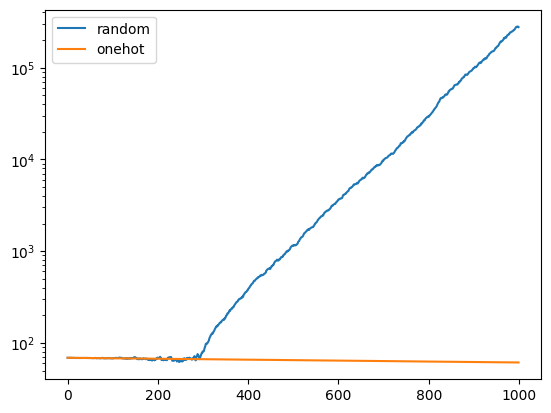

In [83]:
import matplotlib.pyplot as plt

@jax.jit
def compute_targ_Q(mdp: MDP, Q: np.ndarray):
    S, A = Q.shape
    greedy_policy = compute_greedy_policy(Q)
    max_Q = np.sum(greedy_policy * Q, axis=1).reshape(1, 1, S)
    next_v = np.sum(mdp.P * max_Q, axis=-1)
    assert next_v.shape == (S, A)
    return mdp.rew + mdp.gamma * next_v


def do_FQI(mdp: MDP):
    suboptimality = []
    S, A, d = mdp.S, mdp.A, mdp.phi.shape[-1]
    Q = np.zeros(S*A)
    Phi = mdp.phi.reshape(S*A, d)
    K = Phi @ Phi.T
    assert K.shape == (S*A, S*A)
    lr = 0.1

    for _ in range(1000):
        sa_dist = np.random.uniform(0, 1, S*A)
        sa_dist = sa_dist / sa_dist.sum()
        D = np.diag(sa_dist)
        targ_Q = compute_targ_Q(mdp, Q.reshape(S, A)).reshape(S*A)
        Q = Q + lr * K @ D @ (targ_Q - Q)
        suboptimality.append(np.abs(mdp.optimal_Q - Q).max())
    return suboptimality


d = S*A
random_phi = np.random.randn(S, A, d)  # ランダムな特徴ベクトル
mdp = MDP(S_array, A_array, gamma, horizon, rew, P, random_phi)
mdp = mdp._replace(optimal_Q=compute_optimal_Q(mdp).reshape(S*A))
suboptimality = do_FQI(mdp)
plt.plot(suboptimality, label="random")

onehot_phi = np.eye(S*A).reshape(S, A, d)  # one-hot 特徴ベクトル
mdp = MDP(S_array, A_array, gamma, horizon, rew, P, onehot_phi)
mdp = mdp._replace(optimal_Q=compute_optimal_Q(mdp).reshape(S*A))
suboptimality = do_FQI(mdp)
plt.plot(suboptimality, label="onehot")

plt.yscale("log")
plt.legend()

論文ではKの非対角成分が対角成分よりも十分小さくなるのが収束に必要だと説明しています。
今回は適当にランダムなMDPを生成したのでこれが重要でしたが、多分Linear MDPでは違う条件になりそうです。考えてみます。

## ベルマン作用素をもっと一般化

参考： 
* [A Generalized ReinforcementLearning Model Convergence and Application](https://cs.brown.edu/~mlittman/papers/ml96-generalized.pdf)
* 証明や詳細はこっちのほうが詳しいです：[Generalized Markov Decision Processes: Dynamic-programming and Reinforcement-learning Algorithms](https://www.ualberta.ca/~szepesva/papers/gmdp.ps.pdf)
* [An Alternative Softmax Operator for Reinforcement Learning](https://arxiv.org/abs/1612.05628)

強化学習の作用素をもっと一般化させてみましょう。
まず、Q学習の更新は

* 近似ベルマン作用素: $\hat{T}Q(s, a) = r(s, a) + \gamma \max_{a'} Q(s', a')$
* 更新則: $Q_{t+1}(s_t, a_t) \leftarrow Q_{t}(s_t, a_t) + \alpha_t \left(\hat{T}Q_t(s_t, a_t) - Q_t(s_t, a_t)\right)$

でした。このmax作用素を$\otimes$で一般化させると、
* 近似ベルマン作用素: $\hat{T}Q(s, a) = r(s, a) + \gamma \otimes_{a'} Q(s', a')$
* 更新則: $Q_{t+1}(s_t, a_t) \leftarrow Q_{t}(s_t, a_t) + \alpha_t \left(\hat{T}Q_t(s_t, a_t) - Q_t(s_t, a_t)\right)$

とQ学習が一般化できます。例えば$\otimes$をsoftmax作用素などに変更できます。(遷移行列$P$の部分も一般化できますが、今回はこれだけにします。遷移行列を一般化するとrisk-sensitive MDPを一般化できます。)

どのような$\otimes$が適切でしょうか？$\otimes$がnon-expansionであるときに作用素${T}Q(s, a) = r(s, a) + \gamma P(\otimes Q)$はcontraction mappingになります：

* non-expansion: $\otimes_a f_1(x, a) - \otimes_a f_2(x, a) \leq \max_a |f_1(x, a) - f_2(x, a)|$ 
* contraction mapping: $\sup_{x, a} |[TQ_1](x, a) - [TQ_2](x, a)| \leq \gamma \sup_{x, a} |Q_1(x, a) - Q_2(x, a)|$

ちなみにSoftmaxはnon-expansionではありません。なので収束が保証できません。
[論文](https://arxiv.org/abs/1612.05628)のFigure2を再現してみましょう。

In [15]:
import numpy as np
from typing import Optional, NamedTuple
import jax.numpy as jnp

S = 2
A = 2
rew = np.zeros((S, A))
rew[0, 0] = 0.122
rew[0, 1] = 0.033
P = np.zeros((S, A, S))
P[0, 0, 0] = 0.66
P[0, 0, 1] = 0.34
P[0, 1, 0] = 0.99
P[0, 1, 1] = 0.01
P[1, 0, 0] = 0
P[1, 0, 1] = 1
P[1, 1, 0] = 0
P[1, 1, 1] = 1
np.testing.assert_almost_equal(P.sum(axis=-1), 1)
rew, P = jnp.array(rew), jnp.array(P)

S_array = np.arange(S)
A_array = np.arange(A)
gamma = 0.98
horizon = int(1 / (1 - gamma))
mdp = MDP(S_array, A_array, gamma, horizon, rew, P)
mdp = mdp._replace(optimal_Q=compute_optimal_Q(mdp))

In [16]:
# SARSAをします
from tqdm import tqdm
from scipy import special


def do_Q_learning(mdp: MDP, n_episode: int):
    S, A = mdp.S, mdp.A
    horizon = mdp.horizon

    Q_table = np.zeros((S, A))
    lr = 0.1
    eps0 = 0.5

    Q_1_vals = []
    Q_2_vals = []
    num_samples = []
    num_sample = 0

    for e in tqdm(range(n_episode)):
        s = 0
        eps = eps0 * (1 - e / 1000)
        for _ in range(horizon):
            if s == 1:
                break
            a = sample_eps_greedy_act(mdp, Q_table[s], eps)
            next_s = sample_next_state(mdp, s, a)
            greedy_pol = compute_greedy_policy(Q_table)[next_s]
            targ_q = mdp.rew[s, a] + mdp.gamma * np.sum(greedy_pol * Q_table[next_s])
            Q_table[s, a] = lr * targ_q.item() + (1 - lr) * Q_table[s, a]
            s = next_s
            num_sample += 1

        Q_1_vals.append(Q_table[0, 0])
        Q_2_vals.append(Q_table[0, 1])
        num_samples.append(num_sample)
    return num_samples, Q_1_vals, Q_2_vals


def do_SARSA(mdp: MDP, n_episode: int):
    S, A = mdp.S, mdp.A
    horizon = mdp.horizon

    Q_table = np.zeros((S, A))
    lr = 0.1
    beta = 16.55

    Q_1_vals = []
    Q_2_vals = []
    num_samples = []
    num_sample = 0

    for _ in tqdm(range(n_episode)):
        s = 0
        for _ in range(horizon):
            if s == 1:
                break
            softmax_pol = special.softmax(beta * Q_table[s])
            a = np.random.choice(A, p=softmax_pol)
            next_s = sample_next_state(mdp, s, a)
            softmax_pol = special.softmax(beta * Q_table[next_s])
            targ_q = mdp.rew[s, a] + mdp.gamma * np.sum(softmax_pol * Q_table[next_s])
            Q_table[s, a] = lr * targ_q.item() + (1 - lr) * Q_table[s, a]
            s = next_s
            num_sample += 1

        Q_1_vals.append(Q_table[0, 0])
        Q_2_vals.append(Q_table[0, 1])
        num_samples.append(num_sample)
    return num_samples, Q_1_vals, Q_2_vals

n_episode = 2000
Q_num_samples, Q_1, Q_2 = do_Q_learning(mdp, n_episode)
SARSA_num_samples, SARSA_1, SARSA_2 = do_SARSA(mdp, n_episode)

100%|██████████| 2000/2000 [00:57<00:00, 34.85it/s]


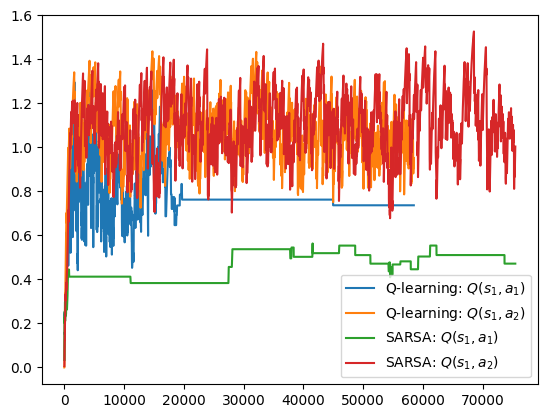

In [17]:
import matplotlib.pyplot as plt

plt.plot(Q_num_samples, Q_1, label=r"Q-learning: $Q(s_1, a_1)$")
plt.plot(Q_num_samples, Q_2, label=r"Q-learning: $Q(s_1, a_2)$")
plt.plot(SARSA_num_samples, SARSA_1, label=r"SARSA: $Q(s_1, a_1)$")
plt.plot(SARSA_num_samples, SARSA_2, label=r"SARSA: $Q(s_1, a_2)$")
plt.legend()

うーん、Figure2は「non-expansionではないsoftmaxでは収束しない」ってことが言いたいみたいですが、誤差のせいでnon-expansionなmaxでも収束してないので、あんまり例としては良くない気がしますね。

今回のベルマン作用素は$(s, a)$に対して次の状態$(s')$が一つランダムに対応する作用素になっています。つまり、確率的に作用素が変化するわけですね。
さらに、Q学習の更新則$Q_{t+1}(s_t, a_t) \leftarrow Q_{t}(s_t, a_t) + \alpha_t \left(\hat{T}Q_t(s_t, a_t) - Q_t(s_t, a_t)\right)$のように、ベルマン作用素自体が$Q_t$に依存することもあります。
そこで、与えられた価値関数からランダムに作用素を返す作用素$T_t: \mathbb{B}(XA) \to (\mathbb{B}(XA)\to\mathbb{B}(XA))$を考え、一般的な更新則：

$$Q_{t+1} = [T_t Q_t] Q'$$

を考えましょう。例えばQ学習の場合にはベルマン作用素は

$$[T_t Q']Q \leftarrow Q' + \alpha_t D_t (r + \gamma P_t (\otimes Q) - Q')$$

と表せます（ここで、$P_t$はランダムにサンプルされた遷移確率です。例えば$(s, a)$を選択して$s'$が出たら、$P_t(s, a, s')=1$かつそれ以外の$y'$に対して$P_t(s, a, y')=0$とすればOK）。FQIなら

$$[T_t Q']Q \leftarrow Q' + \alpha_t K_t D_t (r + \gamma P_t (\otimes Q) - Q') + \mathcal{O}(\|\theta_{t+1}-\theta_{t}\|^2)$$

になるでしょう。
論文のTheorem1は$Q_{t+1}\leftarrow [T_t Q_t] Q_t$が$Q^*$に収束するために十分な条件を与えています。

Pythonでもこの形で適合Q学習を書き直してみましょう。

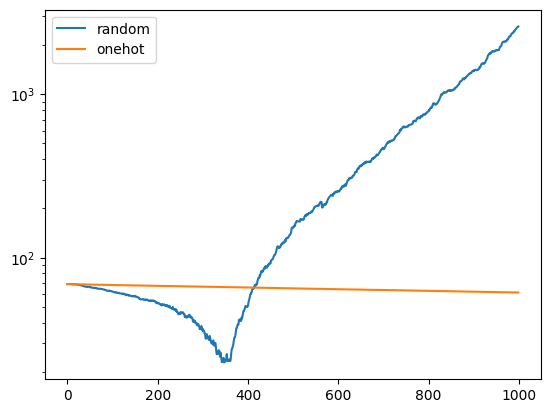

In [100]:
import matplotlib.pyplot as plt
import jax
import chex
from functools import partial

n_step = 10000


def make_generalized_operator(mdp: MDP, otimes):  # T_tです
    # K_tを生成します。今回は一定です。
    S, A = mdp.S, mdp.A
    Phi = mdp.phi.reshape(S*A, -1)
    K_t = Phi @ Phi.T
    chex.assert_shape(K_t, (S*A, S*A))
    S, A = mdp.S, mdp.A
    P = mdp.P.reshape(S*A, S)
    P_choice = partial(jax.random.choice, a=mdp.S_array, shape=(1,), replace=True, axis=0)
    P_choice = jax.vmap(P_choice)
    rew = mdp.rew.reshape(S*A)
    gamma = mdp.gamma

    @jax.jit
    def generalized_operator(key: jax.random.PRNGKey, t: int, Q: np.ndarray):
        Q = Q.reshape(S*A)

        # alpha_tを設定します。今回は0.1で固定してみます。
        alpha_t = 0.1  # 1 - t / n_step

        # D_tを生成します。今回は一様分布からサンプルします。
        key, new_key = jax.random.split(key)
        sa_dist = jax.random.uniform(new_key, shape=(S*A,), minval=0, maxval=1)
        sa_dist = sa_dist / sa_dist.sum()
        D_t = jnp.diag(sa_dist)
        chex.assert_shape(D_t, (S*A, S*A))

        # P_tを生成します。今回はQ学習と同じように一点だけ1にします。
        key, *new_key = jax.random.split(key, num=(S*A + 1))
        new_key = jnp.array(new_key)
        P_t = jnp.zeros((S*A, S))
        nS = P_choice(key=new_key, p=P).reshape(S*A)
        chex.assert_shape(nS, (S*A,))
        P_t = P_t.at[np.arange(S*A), nS].add(1)
        # assert jnp.all(P_t.sum(axis=1) == 1.0)
        chex.assert_shape(P_t, (S*A, S))

        V = otimes(Q.reshape(S, A))
        chex.assert_shape(V, (S,))
        next_v = P_t @ V
        chex.assert_shape(next_v, (S*A,))

        result = Q + alpha_t * K_t @ D_t @ (rew + gamma * next_v - Q)
        chex.assert_shape(result, (S*A,))
        return key, result

    return generalized_operator


def do_generalized_RL(mdp: MDP, operator):
    suboptimality = []
    S, A = mdp.S, mdp.A
    Q = np.zeros(S*A)
    key = jax.random.PRNGKey(0)

    for t in range(1000):
        key, Q = operator(key, t, Q)
        suboptimality.append(np.abs(mdp.optimal_Q - Q).max())
    return suboptimality

max_operator = partial(jnp.max, axis=1)

S = 5
A = 2
d = S*A
random_phi = np.random.randn(S, A, d)  # ランダムな特徴ベクトル
mdp = MDP(S_array, A_array, gamma, horizon, rew, P, random_phi)
mdp = mdp._replace(optimal_Q=compute_optimal_Q(mdp).reshape(S*A))
operator = make_generalized_operator(mdp, max_operator)
suboptimality = do_generalized_RL(mdp, operator)
plt.plot(suboptimality, label="random")

onehot_phi = np.eye(S*A).reshape(S, A, d)  # one-hot 特徴ベクトル
mdp = MDP(S_array, A_array, gamma, horizon, rew, P, onehot_phi)
mdp = mdp._replace(optimal_Q=compute_optimal_Q(mdp).reshape(S*A))
operator = make_generalized_operator(mdp, max_operator)
suboptimality = do_generalized_RL(mdp, operator)
plt.plot(suboptimality, label="onehot")

plt.yscale("log")
plt.legend()

これで行列形式でQ学習の実験もできますね。素晴らしい。